# **CS412 Machine Learning - Recitation 4**
========================================

**Author:** Ece Tosun  
**Date:** November 2025

**Email**: ece.tosun@sabanciuniv.edu

========================================

Due to your HW2, logistic regression implementation and after that is removed in this file.

## **Why Logistic Regression?**
Linear regression can predict any real value, so it fails to constrain outputs between 0 and 1. Logistic regression wraps the linear model inside a sigmoid, allowing us to interpret the result as a probability of the positive class. It keeps the decision boundary linear while enabling probabilistic reasoning and principled optimization through maximum likelihood.

**We need logistic regression because classification is not a regression problem —> it’s a probability decision problem.**

| Aspect | Linear Regression | Logistic Regression |
|--------|------------------|-------------------|
| Output range | (-∞, +∞) | [0, 1] |
| Interpretation | Continuous value | Probability |
| Decision boundary | N/A for classification | Linear hyperplane |
| Optimization | Least squares | Maximum likelihood |
| Use case | Regression | Binary classification |

**Bottom line**: Logistic regression keeps the simplicity and interpretability of linear models while making them suitable for classification through the sigmoid transformation.

<p align="center">
  <img src="log_reg_dem.jpg" width="800">
</p>

## **Binary Classification Setup**
We consider a dataset of $m$ labeled examples $(x^{(i)}, y^{(i)})$ with a single numeric feature: each person's height in centimeters. Labels $y^{(i)} \in \{0, 1\}$ indicate whether the person clears a students threshold (class 1) or not (class 0). Our goal is to learn a weight $w \in \mathbb{R}$ and bias $b \in \mathbb{R}$ so that tall students are predicted as class 1 with high probability.

## **Gradient Descent Focus**
Throughout this recitation we emphasize how different gradient descent strategies behave on the same dataset. We build everything from scratch so that each algebraic step connects directly to the Python implementation.


## **Synthetic Height Dataset**
To keep the story concrete we simulate the heights of two groups. Class 0 represents typical students, while class 1 represents students in team sports who are taller on average. The distributions overlap on purpose so that the optimal logistic model cannot perfectly separate the classes -> gradients still need to negotiate noisy labels

We standardize the heights to zero mean and unit variance for optimization stability.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

## Creating a synthetic dataset of student heights for two distinct groups

In [8]:
rng = np.random.default_rng(42)
n_samples = 220
class1_ratio = 0.5
n_class1 = int(n_samples * class1_ratio)
n_class0 = n_samples - n_class1

# Generates class with random heights sampled from a normal distribution with an average (loc)
# and a standard deviation (scale)
heights_class0 = rng.normal(loc=172, scale=5, size=n_class0)  # typical students
heights_class1 = rng.normal(loc=182, scale=5, size=n_class1)  # students in team sports

heights = np.concatenate([heights_class0, heights_class1])
labels = np.concatenate([np.zeros(n_class0, dtype=int), np.ones(n_class1, dtype=int)])

df = pd.DataFrame({'height': heights,'label': labels}).sample(frac=1.0, random_state=42).reset_index(drop=True)

df.head()

,height,label
0,185.175755,1
1,187.329901,1
2,171.601409,0
3,188.530009,1
4,167.703538,0


In [9]:
X = df[['height']].values
y = df['label'].values

# train vs temp split (70% train, 30% temp)
X_train, X_temp, y_train, y_temp = train_test_split( X, y, test_size=0.30, random_state=42, stratify=y)

# temp into validation vs test (50/50 split -> 15% each overall)
X_val, X_test, y_val, y_test = train_test_split( X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print("Train set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

Train set size: 154
Validation set size: 33
Test set size: 33


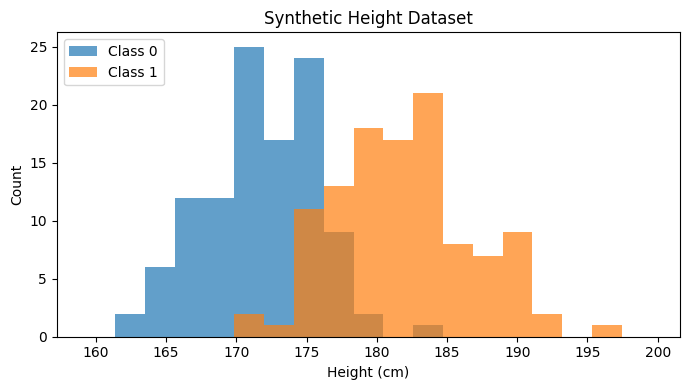

In [10]:
fig, ax = plt.subplots(figsize=(7, 4))
bins = np.linspace(X.min() - 3, X.max() + 3, 20) # for clarity
ax.hist(df.loc[y == 0, 'height'], bins=bins, alpha=0.7, label='Class 0')
ax.hist(df.loc[y == 1, 'height'], bins=bins, alpha=0.7, label='Class 1') # alpha for transparency
ax.set_xlabel('Height (cm)')
ax.set_ylabel('Count')
ax.set_title('Synthetic Height Dataset')
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

Before learning Logistic Reg. and SGD lest first split our dataset

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train) # never fit on X, you would leak information from your test set

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## **From Linear Regression to Logistic Regression**
Linear regression treats the binary labels as numbers and searches for a straight line that minimizes squared error. That line can wander outside the $[0, 1]$ interval, so its "probabilities" are hard to interpret and it makes fragile classification decisions. Logistic regression keeps the same linear score $z = wx + b$ but passes it through the sigmoid, constraining predictions between 0 and 1.

1. Linear Regression outputs are unbounded -> bad when we are dealing with probabilistic calculations
2. MSE is the wrong loss for classification
3. **Classification is inherently non-linear in probability space**

## **Sigmoid Hypothesis**
(log odds -> the coefficient normalized by the standard error) 

Logistic regression models the log-odds of the positive class as a linear function of the inputs:

$$
z^{(i)} = \mathbf{w}^\top \mathbf{x}^{(i)} + b.
$$

Applying the logistic sigmoid yields the predicted probability:

$$
\hat{y}^{(i)} = \sigma\left(z^{(i)}\right) = \frac{1}{1 + e^{-z^{(i)}}}.
$$

Because $\sigma(z) \in (0, 1)$ for all $z \in \mathbb{R}$, the model outputs well-calibrated probabilities.


### **Sigmoid Properties**
- $\sigma(0) = 0.5$ so the decision boundary occurs where $z = 0$.
- The derivative is $\sigma(z)(1-\sigma(z))$, which is largest near the boundary and vanishes far away, influencing gradient magnitudes.
- The logit function $\text{logit}(p) = \log\frac{p}{1-p}$ is the inverse of the sigmoid, so logistic regression is a linear model in log-odds space.


<img src="sigmoid.png" width="500">

## **Likelihood and Cross-Entropy Loss**

Assuming independent samples, the likelihood of observing the labels given the parameters is

$$
\mathcal{L}(\mathbf{w}, b) = \prod_{i=1}^{m} \sigma(z^{(i)})^{y^{(i)}} \left(1 - \sigma(z^{(i)})\right)^{1 - y^{(i)}}.
$$

---

#### From Likelihood to Cross-Entropy Loss (Step-by-Step)

We model each binary label using a Bernoulli distribution:

$$
\hat{y}^{(i)} = \sigma(z^{(i)}) = \sigma(w^T x^{(i)} + b)
$$

---

#### Likelihood of observing the data

Assuming independent samples:

$$
\mathcal{L}(w,b) = \prod_{i=1}^{m}
\left( \hat{y}^{(i)} \right)^{y^{(i)}} 
\left( 1 - \hat{y}^{(i)} \right)^{\left(1 - y^{(i)}\right)}
$$

A product appears because we assume all samples are **independent**.

---

#### Take log → Convert product to sum

$$
\ell(w,b) 
= \log \mathcal{L}(w,b)
= \sum_{i=1}^{m}
\Big[
y^{(i)} \log \hat{y}^{(i)} +
(1 - y^{(i)}) \log(1 - \hat{y}^{(i)})
\Big]
$$

> Taking the logarithm simplifies differentiation and improves numerical stability.

---

#### Convert maximization to minimization

Learning ≈ optimization → we minimize a **loss**, not maximize likelihood:

$$
J(w,b)
= -\frac{1}{m}\,\ell(w,b)
= -\frac{1}{m}\sum_{i=1}^{m}
\Big[
y^{(i)} \log \hat{y}^{(i)} +
(1 - y^{(i)}) \log(1 - \hat{y}^{(i)})
\Big]
$$

---

### Final Result: Binary Cross-Entropy Loss

$$
\boxed{
J(w,b)
= -\frac{1}{m}\sum_{i=1}^{m}
\Big[
y^{(i)} \log \hat{y}^{(i)} +
(1 - y^{(i)}) \log(1 - \hat{y}^{(i)})
\Big]
}
$$

This loss:
- penalizes **confident wrong predictions** heavily
- is **convex** in $w$ and $b$
- gives a **probabilistically meaningful** objective

## **Logistic Regression Gradient Derivation**

---

### Step 1 - Loss Function (Single Sample)

For binary classification, the loss for one example is:

$$
\ell^{(i)} = -\left[y^{(i)} \log \hat{y}^{(i)} + (1-y^{(i)})\log(1-\hat{y}^{(i)})\right]
$$

**Where:**
- $x^{(i)}$ → input
- $y^{(i)} \in \{0,1\}$ → true label
- $\hat{y}^{(i)}$ → predicted probability

---

### Step 2 - Logistic Regression Model (Forward)

$$
z^{(i)} = w^\top x^{(i)} + b
$$

$$
\hat{y}^{(i)} = \sigma(z^{(i)}) = \frac{1}{1 + e^{-z^{(i)}}}
$$

**So the chain is:**

$$
\ell^{(i)} \rightarrow \hat{y}^{(i)} \rightarrow z^{(i)} \rightarrow (w, b)
$$

---

### Step 3 - Chain Rule Components

We need:

$$
\frac{\partial \ell^{(i)}}{\partial w}, \quad
\frac{\partial \ell^{(i)}}{\partial b}
$$

#### A) Loss w.r.t. prediction:

$$
\frac{\partial \ell^{(i)}}{\partial \hat{y}^{(i)}}
= -\frac{y^{(i)}}{\hat{y}^{(i)}} + \frac{1-y^{(i)}}{1-\hat{y}^{(i)}}
$$

#### B) Prediction w.r.t. logit:

$$
\frac{\partial \hat{y}^{(i)}}{\partial z^{(i)}}
= \hat{y}^{(i)}(1 - \hat{y}^{(i)})
$$

*(sigmoid derivative makes it a very good binary classification model)*

#### C) Logit w.r.t. parameters:

$$
\frac{\partial z^{(i)}}{\partial w} = x^{(i)}, \quad
\frac{\partial z^{(i)}}{\partial b} = 1
$$

---

### Step 4 - Combine with Chain Rule

$$
\frac{\partial \ell^{(i)}}{\partial z^{(i)}}
=
\frac{\partial \ell^{(i)}}{\partial \hat{y}^{(i)}}
\cdot
\frac{\partial \hat{y}^{(i)}}{\partial z^{(i)}}
=
\hat{y}^{(i)} - y^{(i)}
$$

---

### Single-Sample Gradients (Used for SGD)

$$
\frac{\partial \ell^{(i)}}{\partial w}
= (\hat{y}^{(i)} - y^{(i)}) x^{(i)}
$$

$$
\frac{\partial \ell^{(i)}}{\partial b}
= (\hat{y}^{(i)} - y^{(i)})
$$

---

### Batch Gradient (All Training Samples, used for Full-Batch)

Let:
- $m$ = number of samples
- $\hat{y}$ = model predictions vector

**Then gradients are:**

$$
\nabla_w J
= \frac{1}{m} X^\top(\hat{y}-y)
$$

$$
\frac{\partial J}{\partial b}
= \frac{1}{m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)})
$$

---

### Gradient Descent Update Rules

**These gradients are what gradient descent uses to update the model:**

$$
w := w - \eta \nabla_w J
$$

$$
b := b - \eta \frac{\partial J}{\partial b}
$$

where $\eta$ is the learning rate.

---

#### Think this term as the error so we can update our weights accordingly:

$$
(\hat{y}^{(i)} - y^{(i)})
$$

The model intuitively says that “If I'm wrong, change weights in the opposite direction of the error.”

---

This derivation shows why logistic regression is such a fundamental algorithm in machine learning

The gradient has a natural interpretation as the prediction error, weighted by the input features.

## **Gradient Descent Algorithms**
Let $\eta$ denote the learning rate. A generic gradient descent update has the form

$$
\mathbf{w} \leftarrow \mathbf{w} - \eta \, \nabla_{\mathbf{w}} J, \qquad
b \leftarrow b - \eta \, \frac{\partial J}{\partial b}.
$$

- **Batch gradient descent** uses the full dataset for each gradient evaluation. It provides stable steps but can be expensive for large $m$.
- **Stochastic gradient descent (SGD)** updates parameters after every single example. It introduces gradient noise that can help escape shallow regions and enables streaming over large datasets. It shuffles the dataset and sample from it one by one.

## **Stochastic Sampling Mechanics**
Stochastic gradient descent processes one example at a time:
1. Start from the list of sample indices $0, \ldots, m-1$.
2. Shuffle the order to create a fresh traversal for the epoch.
3. Pick the next index, pull out $(x^{(i)}, y^{(i)})$, compute the gradients from that single example, and update $(w, b)$ immediately.
4. Repeat until the epoch ends, then reshuffle for the next pass.



### Understanding SGD vs Full-Batch Gradient Descent

When we set `steps` equal to the total number of training samples,  
**SGD completes one full epoch**: it sees every sample once and performs one weight update per sample.

However, this is still **not full-batch gradient descent** — the gradient update style is different:

- **Full-Batch GD:** Performs **1 update per epoch** using the **average gradient** of *all* samples.  
- **SGD:** Performs **many updates per epoch** (one per sample), using **only a single sample’s gradient** each time.

So even though both methods have seen the **entire dataset**,  
their **learning behavior**, **loss curves**, and **convergence characteristics** are very different.
